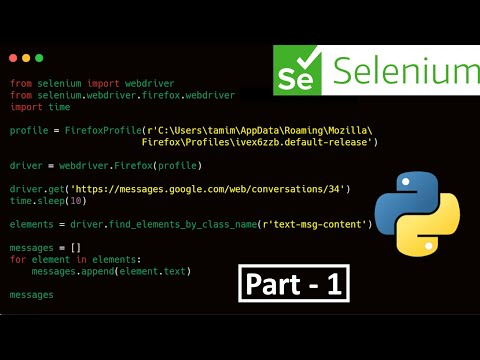

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('7uDYFF54d64', width=960, height='540' )

In [ ]:
# your default firefox progile directory in your pc.
user_firefox_profile = r'C:\Users\username\AppData\Roaming\Mozilla\Firefox\Profiles\ivex6zzb.default-release'

# url for your perticular SMS thread
bkash_sms_url = 'https://messages.google.com/web/conversations/123'

# sheet id from your google sheet, for detail understanding, please watch the attached youtube video.
google_sheet_id = '1LpVcbIMFzY7ZoX42J5v5r7uDnG4AaNPW2jOzvK-EYE0'

# transection id column name in your google sheet.
joining_column_name = 'Transection_ID' 

# file name for save validation data in your pc, it must be a csv file.
file_name = 'validated_data.csv' 

# your gmail address, it will be used for sendng mail.
sender = 'yourgmailabcxyz@gmail.com'

# password for your gmail account. please refer to the video instruction.
credential = 'hxtmadtlwbdiyfg'

# your mail subject.
subject = ''

# text of your mail body.
mail_body = ''''''

In [ ]:
# !pip install selenium
# !pip install pandas
# !pip install yagmail

In [ ]:
from selenium import webdriver
from selenium.webdriver.firefox.webdriver import FirefoxProfile
import time

profile = FirefoxProfile(user_firefox_profile)
driver = webdriver.Firefox(profile)
driver.get('https://messages.google.com/web')

In [ ]:
driver.get(bkash_sms_url)
time.sleep(10)

In [ ]:
elements = driver.find_elements_by_class_name(r'text-msg-content')

messages = []
for element in elements:
    messages.append(element.text)

messages

In [ ]:
import re
import pandas as pd


def transection_type(input_string=''):
    transec_type_dict = {
        'cash_in': 'Cash In Tk',
        'cash_out': 'Cash Out Tk',
        'send_money': 'Send Money Tk',
        'receive_money': 'You have received Tk'
    }
    for key in transec_type_dict:
        if transec_type_dict[key] in input_string:
            return key
    else:
        return 'unknown'


def extract_info(input_string=''):
    pattern_dict = {
        'trxId': r'\b[A-Z\d]{10}\b',
        'phn_num': r'01[3-9]\d{8}',
        'tk_amount': r'[\d,]+\.\d+',
        'date_time': r'[\d/]+ \d+:\d+'
    }
    info_dict = {}
    for key in pattern_dict:
        info_dict[key] = re.findall(pattern_dict[key], input_string)[0]
    info_dict['transec_type'] = transection_type(input_string)
    info_dict['mail_status'] = None
    return info_dict


info_list = []
for message in messages:
    if re.findall(r'01[3-9]\d{8}', message):
        info_list.append(extract_info(message))
    else:
        continue

info_df = pd.DataFrame(info_list)
info_df

In [ ]:
import os
# google_sheet_location = 'https://docs.google.com/spreadsheets/d/1LpVcbIMFzY7ZoX42J5v5r7uFuF4AaNPW2jOzvK-EYE0/export?format=csv'
google_sheet_location = f'https://docs.google.com/spreadsheets/d/{google_sheet_id}/export?format=csv'

client_df = pd.read_csv(google_sheet_location)
joined_df = pd.merge(left=client_df,
                     right=info_df,
                     left_on=joining_column_name,
                     right_on='trxId',
                     how='left')

if os.path.exists(file_name):
    previous_df = pd.read_csv(file_name)
    new_info_df = joined_df[~joined_df[joining_column_name].isin(previous_df[joining_column_name])]
    updated_df = pd.concat([previous_df, new_info_df])
    updated_df.to_csv(file_name, index=False)
else:
    joined_df.to_csv(file_name, index=False)

joined_df

In [ ]:
import yagmail

yag = yagmail.SMTP(sender, credential)

mail_df = pd.read_csv(file_name)


def mail_n_update(row):
    if row['mail_status'] != 'sent':
        if pd.isna(row['trxId']):
            row['mail_status'] = 'skipped'
            row['transec_type'] = 'not_matched!'
            print(row.name, row['Name'], '<trxId not matched>')
        else:
            try:
                yag.send(to=row['email'], subject=subject, contents=mail_body)
                row['mail_status'] = 'sent'
                print(row.name, row['Name'], '<sent>')
            except:
                row['mail_status'] = 'failed'
                print(row.name, row['Name'], '<failed>')
    else:
        print(row.name, row['Name'], '<previously sent>')
    return row


mail_df = mail_df.apply(mail_n_update, axis=1)
mail_df = mail_df[joined_df.columns]

mail_df.to_csv(file_name, index=False)
mail_df